# Sustainability scores processing

BC3 provides access to static results (Colombia at 1km resolution) for a sustainability score per each of the four dimensions (see mor info [here](https://drive.google.com/file/d/1wh0QTN89Zs8Cpsh32mgiTMYA5-yKPykB/view?usp=sharing)). Particularly useful for Vizzuality to build their side of the MVP, while access to k.LAB via API is a work in progress:

[Data source](https://drive.google.com/drive/folders/19I7d9xDHxZtRHW9tG166JhWeoagbVdBD?usp=sharing)

## Purpose

The purpose of this notebooks is to vectorized the 4 dimensions scores into three different scales:
- Municipalities ([data source](https://basecamp.com/1756858/projects/18107300/messages/99371742?enlarge=452957920#attachment_452957920))
- HeCo Mosaics ([data source](https://basecamp.com/1756858/projects/18107300/messages/99371742?enlarge=450698651#attachment_450698651))
- Hydrological basins ([data source](https://data.apps.fao.org/aquamaps/))


## Setup

### Library import

We import all the required Python libraries

In [1]:
import os
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray
import rasterio
import regionmask
import cartopy.crs as ccrs
from shapely.geometry import MultiPolygon
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Utils

**create_ds_mask**

In [2]:
def set_lat_lon_attrs(ds, lon_name='lon', lat_name='lat'):
    """ Set CF latitude and longitude attributes"""
    ds[lon_name] = ds[lon_name].assign_attrs({
      'axis' : 'X',
       'long_name' : 'longitude',
        'standard_name' : 'longitude',
         'stored_direction' : 'increasing',
          'type' : 'double',
           'units' : 'degrees_east',
            'valid_max' : 360.0,
             'valid_min' : -180.0
             })
    ds[lat_name] = ds[lat_name].assign_attrs({
      'axis' : 'Y',
       'long_name' : 'latitude',
        'standard_name' : 'latitude',
         'stored_direction' : 'increasing',
          'type' : 'double',
           'units' : 'degrees_north',
            'valid_max' : 90.0,
             'valid_min' : -90.0
             })
    return ds

def create_ds_mask(df, ds, name, lon_name='lon', lat_name='lat'):
    """Create masks of geographical regions"""
    # Create index column
    if 'index' not in df:
        df = df.reset_index(drop=True).reset_index()

    # Extract indexes and geoms that are large enough!
    id_ints = df['index'].values
    geoms = df['geometry'].values
    
    print(f'Number of indexes: {len(id_ints)}')
    print(f'Number of geoms: {len(geoms)}')


    # create mask object
    da_mask = regionmask.Regions(
      name = name,
      numbers = id_ints,
      outlines = geoms)\
      .mask(ds, lon_name=lon_name, lat_name=lat_name)\
      .rename(name)

    # get the ints actually written to mask
    id_ints_mask = da_mask.to_dataframe().dropna()[name].unique()
    id_ints_mask = np.sort(id_ints_mask).astype('int')
    
    print(f'Number of ints in mask: {len(id_ints_mask)}')
    
    # get the ints not written to mask
    id_ints_not_in_mask = df[~df['index'].isin(id_ints_mask)]['index'].values
    
    if len(id_ints_not_in_mask) > 0: 
        print(f'Ints not in mask: {id_ints_not_in_mask}')
    
    # update da attributes
    da_mask.attrs['id_ints'] = id_ints_mask
    da_mask = set_lat_lon_attrs(da_mask, lon_name, lat_name)
    
    return da_mask, id_ints_not_in_mask

# Data import
We retrieve all the data required for the analysis.
## Raster data
### Sustainability scores
**Read data**

In [3]:
dir_path = '../../datasets/raw/sustainability_scores'
file_dict = {'biodiversity': 'Biodiversity.tiff',
'climate': 'Climate.tiff',
'community': 'Community.tiff',
'water': 'Water.tiff'}

for key, value in file_dict.items():
    ds_tmp = xr.open_dataset(f'{dir_path}/{value}').squeeze().drop("band").rename({'band_data': key})
    if key == 'biodiversity':
        ds = ds_tmp
    else:
        ds[key] = ds_tmp[key]

ds

<xarray.Dataset>
Dimensions:       (x: 1348, y: 1846)
Coordinates:
  * x             (x) float64 -79.01 -79.0 -78.99 ... -66.89 -66.88 -66.87
  * y             (y) float64 12.45 12.44 12.44 12.43 ... -4.206 -4.215 -4.224
    spatial_ref   int64 ...
Data variables:
    biodiversity  (y, x) float32 ...
    climate       (y, x) float32 ...
    community     (y, x) float32 ...
    water         (y, x) float32 ...

**Display data**

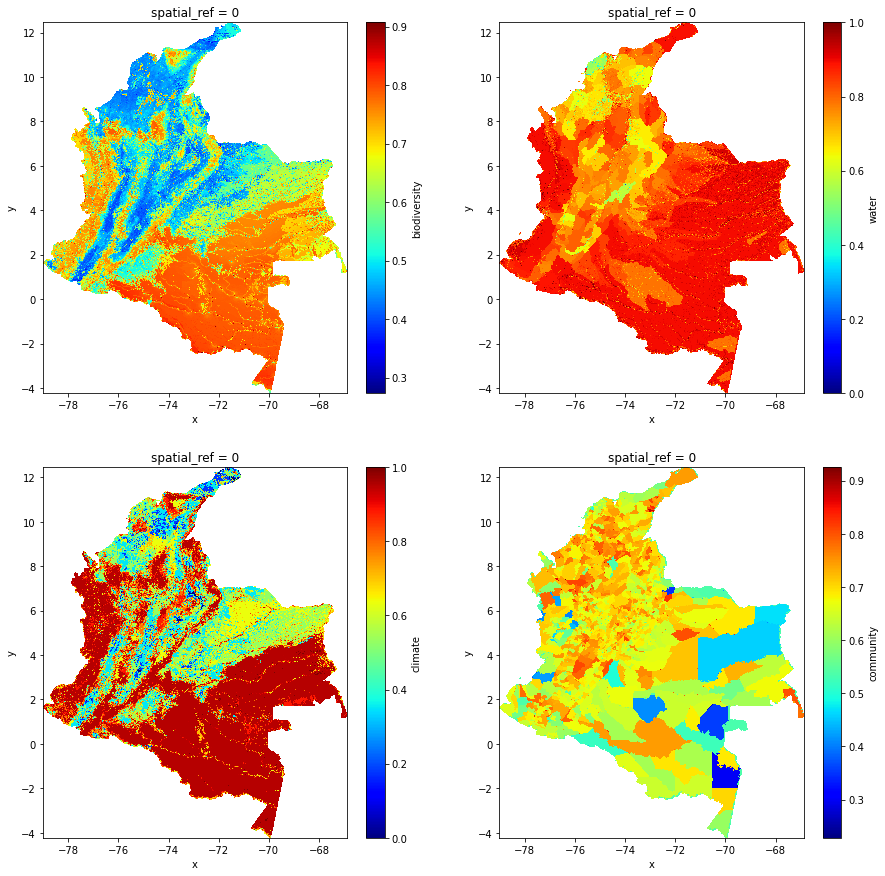

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(15,15))

ds['biodiversity'].plot(ax=ax[0,0], cmap='jet')
ds['climate'].plot(ax=ax[1,0], cmap='jet')
ds['water'].plot(ax=ax[0,1], cmap='jet')
ds['community'].plot(ax=ax[1,1], cmap='jet')

## Vector data 
### Municipalities
**Read data**

In [5]:
municipalities = gpd.read_file('../../datasets/processed/municipalities.geojson')
municipalities.head(1)

,nombre_ent,categoria,departamen,cod_depart,cod_munici,area_km,geometry
0,MEDELLÍN,M,ANTIOQUIA,05,001,372.897934,"POLYGON ((-75.66878 6.37300, -75.66802 6.37249..."


**Display geometries**

<AxesSubplot:>

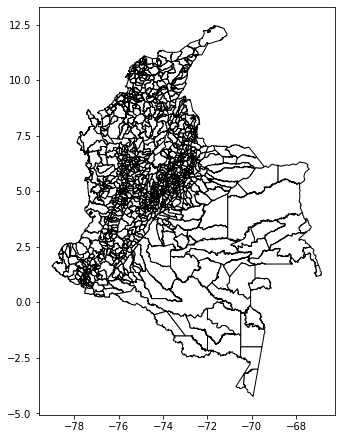

In [6]:
fig, ax = plt.subplots(figsize=(7.5,7.5))
municipalities.plot(ax=ax, color='w', edgecolor='k')

### HeCo Mosaics
**Read data**

In [8]:
mosaics = gpd.read_file('../../datasets/processed/mosaics.geojson')
mosaics.head(1)

,mosaico,area_ha,geometry
0,Cordillera Oriental,2.571763e+06,"POLYGON Z ((-73.20833 8.23750 0.00000, -73.207..."


**Display geometries**

<AxesSubplot:>

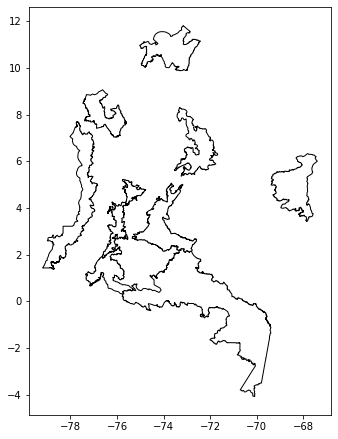

In [9]:
fig, ax = plt.subplots(figsize=(7.5,7.5))
mosaics.plot(ax=ax, color='w', edgecolor='k')

### Hydrological basins
**Read data**

In [10]:
basins = gpd.read_file('../../datasets/processed/basins.geojson')
basins.head(1)

,maj_name,maj_bas,sub_name,sub_bas,geometry
0,Caribbean Coast,3001,Archipielago de San Blas Coast,1002,"MULTIPOLYGON (((-77.07500 8.32035, -77.07529 8..."


**Display geometries**

<AxesSubplot:>

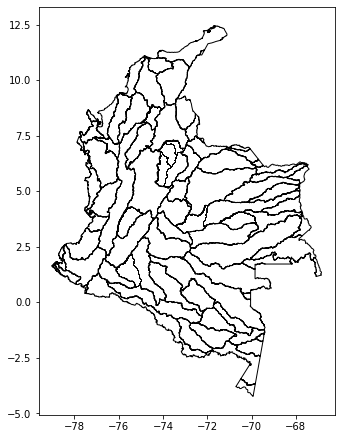

In [37]:
fig, ax = plt.subplots(figsize=(7.5,7.5))
basins.plot(ax=ax, color='w', edgecolor='k')

## Parameter definition
We set all relevant parameters for our notebook. 

**Put all vector data together** 

In [38]:
gdf_vectors = {"municipalities": municipalities,
    "mosaics": mosaics,
    "basins": basins}

# Data processing
## Zonal statistics
We convert raster data into vector by taking the mean value of each indicator at every geometry.
### Rasterize vector data
**Create the data mask by rasterizing the vector data**

In [39]:
da_mask = {}
ids_not_in_mask = {}
for gdf_name, gdf in gdf_vectors.items():
    print(gdf_name)
    #Create the data mask by rasterizing the vector data
    gdf = gdf.reset_index(drop=True).copy()
    da_mask[gdf_name], ids_not_in_mask[gdf_name] = create_ds_mask(gdf.copy(), ds, name=gdf_name.lower().replace(' ', '_'), lon_name='x', lat_name='y')

municipalities
Number of indexes: 1121
Number of geoms: 1121


/opt/conda/lib/python3.8/site-packages/regionmask/core/regions.py:410: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for p in poly:


Number of ints in mask: 1121
mosaics
Number of indexes: 9
Number of geoms: 9
Number of ints in mask: 9
basins
Number of indexes: 83
Number of geoms: 83


/opt/conda/lib/python3.8/site-packages/regionmask/core/regions.py:410: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for p in poly:


Number of ints in mask: 83


**Display masks**

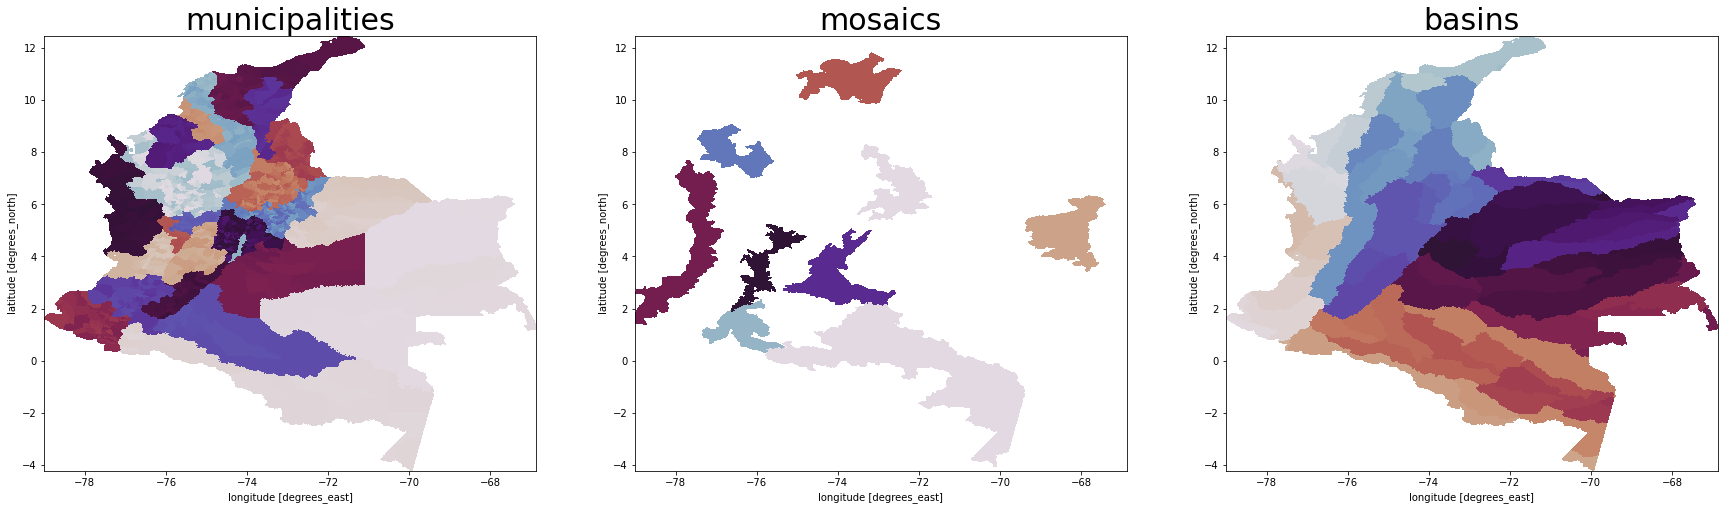

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(30,8))

n=0
for geo_name, mask in da_mask.items():
    mask.plot.pcolormesh(ax=axs[n], cmap='twilight', x='x', y='y', add_colorbar=False)
    axs[n].set_title(geo_name, fontsize=30);
    n+=1 

### Compute mean values for each indicator and time 
**Add mask as a new variable into the xarray.Dataset**

In [41]:
for geo_name, mask in da_mask.items():
    print(geo_name)
    ds[geo_name.lower().replace(' ', '_')] = mask

ds

municipalities
mosaics
basins


<xarray.Dataset>
Dimensions:         (x: 1348, y: 1846)
Coordinates:
  * x               (x) float64 -79.01 -79.0 -78.99 ... -66.89 -66.88 -66.87
  * y               (y) float64 12.45 12.44 12.44 12.43 ... -4.206 -4.215 -4.224
    spatial_ref     int64 0
Data variables:
    biodiversity    (y, x) float32 ...
    climate         (y, x) float32 ...
    community       (y, x) float32 ...
    water           (y, x) float32 ...
    municipalities  (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    mosaics         (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    basins          (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan

**Compute mean values**

In [44]:
gdf_indicators = gdf_vectors.copy()
for gdf_name, mask in da_mask.items():
    print(gdf_name)
    gdf = gdf_indicators[gdf_name]
    indicators = list(ds.keys())[:len(da_mask.keys())*-1]
    for indicator in indicators:
        print(indicator)
        mean_values = [] 
        for index in tqdm(ds[gdf_name.lower().replace(' ', '_')].attrs['id_ints']):
            mean_values.append(ds[indicator].where(ds[gdf_name.lower().replace(' ', '_')] == index).mean(['x', 'y']).values)

        df = pd.DataFrame({'index': list(ds[gdf_name.lower().replace(' ', '_')].attrs['id_ints']),\
                          indicator: mean_values}).astype({indicator: float})
                           
        # compute demand   
        df[f'{indicator}_demand'] = df[indicator].apply(lambda x: 1-x)

        gdf = pd.merge(gdf.reset_index(), df, how = 'left', on = 'index').drop(columns='index')
        
        lst = list(gdf.columns)
        lst.append(lst.pop(lst.index('geometry')))
        gdf = gdf[lst]

    gdf_indicators[gdf_name] = gdf

municipalities
biodiversity


100%|██████████| 1121/1121 [00:10<00:00, 111.03it/s]


climate


100%|██████████| 1121/1121 [00:10<00:00, 111.99it/s]


community


100%|██████████| 1121/1121 [00:10<00:00, 109.98it/s]


water


100%|██████████| 1121/1121 [00:10<00:00, 106.86it/s]


mosaics
biodiversity


100%|██████████| 9/9 [00:00<00:00, 101.62it/s]


climate


100%|██████████| 9/9 [00:00<00:00, 103.46it/s]


community


100%|██████████| 9/9 [00:00<00:00, 95.73it/s]


water


100%|██████████| 9/9 [00:00<00:00, 102.46it/s]


basins
biodiversity


100%|██████████| 83/83 [00:00<00:00, 107.70it/s]


climate


100%|██████████| 83/83 [00:00<00:00, 98.99it/s] 


community


100%|██████████| 83/83 [00:00<00:00, 105.86it/s]


water


100%|██████████| 83/83 [00:00<00:00, 107.88it/s]


**Save regions as GeoJSON**

In [49]:
for gdf_name, gdf in gdf_indicators.items():
    print(gdf_name)
    gdf.to_file(f'../../datasets/processed/{gdf_name}_demand.geojson', driver='GeoJSON') 

municipalities
mosaics
basins


### Display outputs
**Sustainability scores**

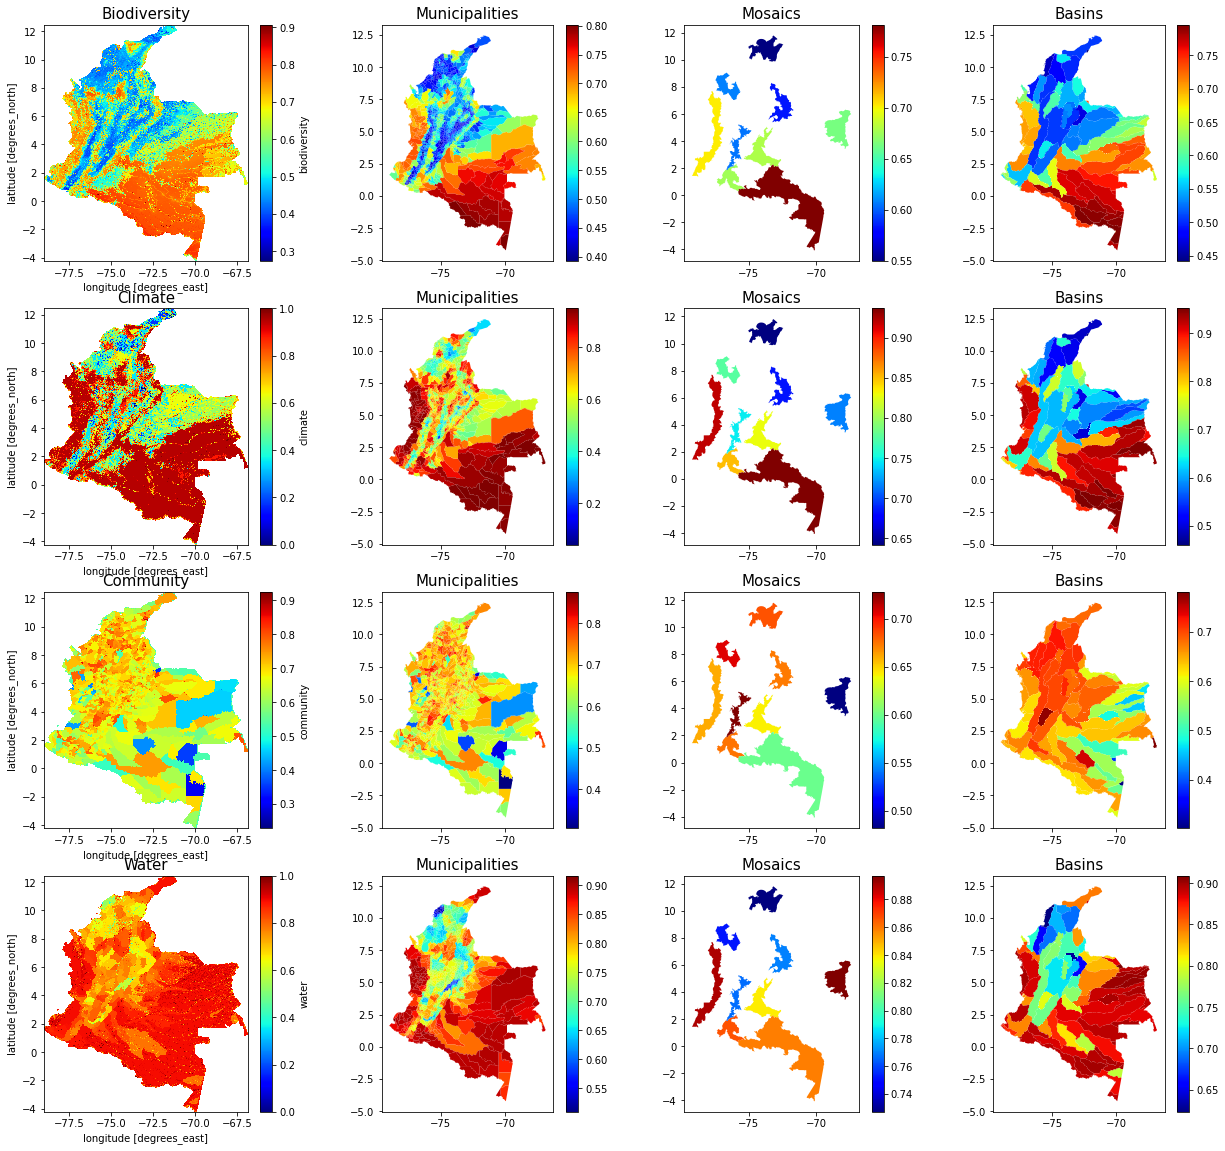

In [98]:
indicators = list(ds.keys())[:len(da_mask.keys())*-1]
fig, ax = plt.subplots(4, 4, figsize=(21,20))
for i, indicator in enumerate(indicators):
    ds[indicator].plot(ax=ax[i, 0], cmap='jet')
    ax[i, 0].set_title(indicator.capitalize(), fontsize=15)
    for j, gdf_name in enumerate(da_mask.keys()):
        gdf_indicators[gdf_name].plot(ax=ax[i, j+1], column=indicator, cmap='jet', legend=True)
        ax[i, j+1].set_title(gdf_name.capitalize(), fontsize=15)

**Sustainability demans**

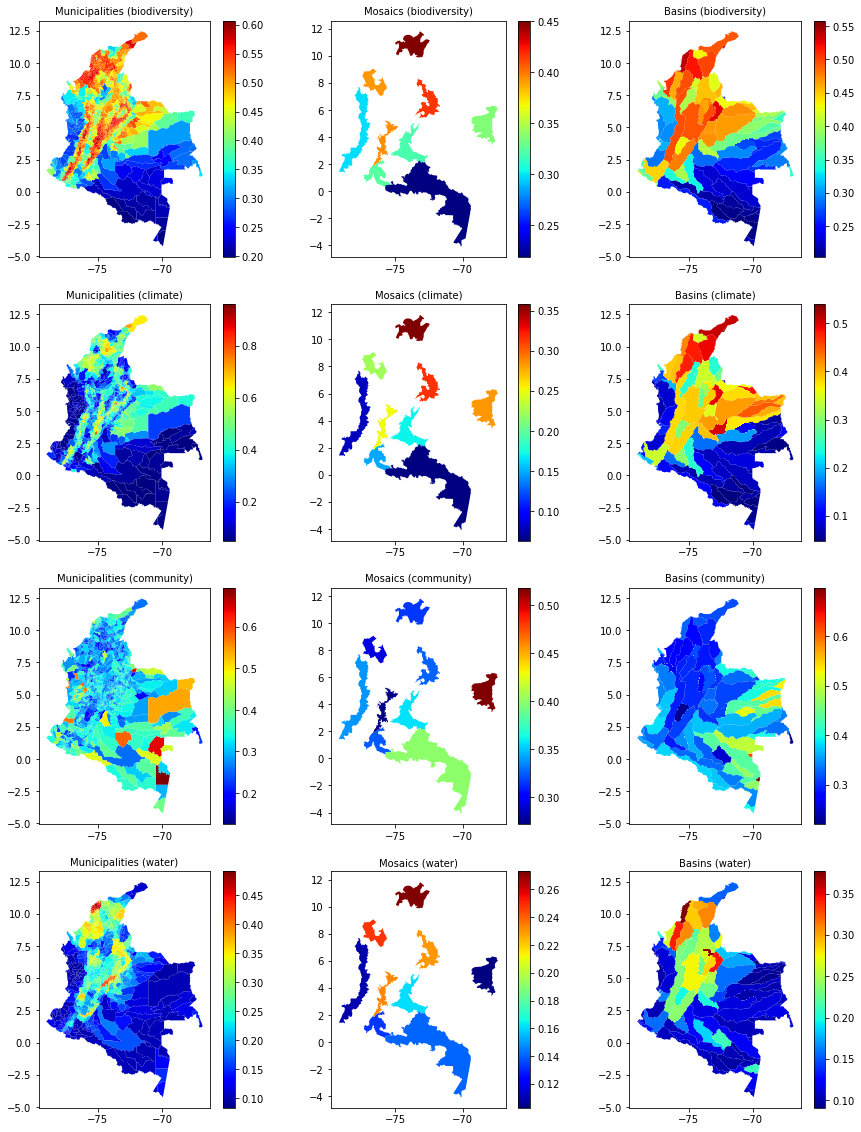

In [102]:
indicators = list(ds.keys())[:len(da_mask.keys())*-1]
fig, ax = plt.subplots(4, 3, figsize=(15,20))
for i, indicator in enumerate(indicators):
    for j, gdf_name in enumerate(da_mask.keys()):
        gdf_indicators[gdf_name].plot(ax=ax[i, j], column=f'{indicator}_demand', cmap='jet', legend=True)
        ax[i, j].set_title(f'{gdf_name.capitalize()} ({indicator})', fontsize=10)